# Social Media Engagement Model

This project explores what drives post-level social media engagement using a using a Kaggle dataset of 731 posts. The goal was to model an **Engagement Score**, defined as:

> **Engagement Score = Likes + (2 × Retweets)**

This weighting reflects the strategic belief that shares (retweets) contribute more to visibility and reach than likes. The project leverages feature engineering, XGBoost + CatBoost modeling, and SHAP explainability to identify the most impactful factors behind engagement.


https://www.kaggle.com/code/ahmedraft/social-media-analysis


## 2. Project Workflow

- **Data Cleaning**  
  Removed duplicates, standardized text fields, and filtered out edge cases (e.g., zero engagement, future timestamps).

- **Feature Engineering**  
  Created variables based on timing, structure, hashtags, and sentiment. Combined features to capture interactions like `Sentiment_HourBin` and `Char_Per_Hashtag_Bin`. 

- **Model Training**  
  Trained and tuned a CatBoost Regressor using Repeated K-Fold CV. XGBoost was also explored, but CatBoost offered better generalization and cleaner interpretability.

- **Explainability**  
  Used SHAP to evaluate feature contributions and guide refinement. Unimportant features were dropped or restructured.

- **Visualization**  
  Tableau dashboard built for pattern exploration across time, platform, sentiment, and country. Supports SUM/AVG engagement toggling.

In [5]:
import pandas as pd
import numpy as np
import re
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from xgboost import XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [30]:
df = pd.read_csv("sentiment_dataset.csv")

print("Row count:", len(df))
df.info()
df.head()

# Null check
print("\nNull values:\n", df.isnull().sum())

# Duplicate check
print("\nDuplicate rows:", df.duplicated().sum())

# Visually confirm duplicates before dropping
duplicate_rows = df[df.duplicated(keep=False)]
duplicates_sorted = duplicate_rows.sort_values(by=df.columns.tolist())
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

display(duplicates_sorted.head(5))

Row count: 732
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       732 non-null    object
 1   Sentiment  732 non-null    object
 2   Timestamp  732 non-null    object
 3   User       732 non-null    object
 4   Platform   732 non-null    object
 5   Hashtags   732 non-null    object
 6   Retweets   732 non-null    int64 
 7   Likes      732 non-null    int64 
 8   Country    732 non-null    object
 9   Year       732 non-null    int64 
 10  Month      732 non-null    int64 
 11  Day        732 non-null    int64 
 12  Hour       732 non-null    int64 
dtypes: int64(6), object(7)
memory usage: 74.5+ KB

Null values:
 Text         0
Sentiment    0
Timestamp    0
User         0
Platform     0
Hashtags     0
Retweets     0
Likes        0
Country      0
Year         0
Month        0
Day          0
Hour         0
dtype: int64

Duplicate rows: 21


,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
278,"A compassionate rain, tears of empathy falling gently, nurturing the seeds of kindness in the garden of human connections.",Compassionate,2021-07-01 12:10:00,RainNurturer,Instagram,#Compassionate #TearsOfEmpathy,21,42,Canada,2021,7,1,12
292,"A compassionate rain, tears of empathy falling gently, nurturing the seeds of kindness in the garden of human connections.",Compassionate,2021-07-01 12:10:00,RainNurturer,Instagram,#Compassionate #TearsOfEmpathy,21,42,Canada,2021,7,1,12
271,"A free spirit soaring on the wings of dreams, leaving trails of independence in the azure sky of boundless possibilities.",Free-spirited,2020-06-10 10:05:00,DreamSoarer,Twitter,#FreeSpirit #WingsOfDreams,22,44,UK,2020,6,10,10
285,"A free spirit soaring on the wings of dreams, leaving trails of independence in the azure sky of boundless possibilities.",Free-spirited,2020-06-10 10:05:00,DreamSoarer,Twitter,#FreeSpirit #WingsOfDreams,22,44,UK,2020,6,10,10
267,"A playful escapade in the carnival of life, carousel laughter and cotton candy dreams swirling in the joyous atmosphere.",Playful,2018-08-22 17:20:00,CarnivalDreamer,Facebook,#Playful #CarnivalEscapade,24,48,Australia,2018,8,22,17


## 3. Data Preparation

This section includes standard steps used to prepare the dataset for modeling:

- Removed duplicate and near-duplicate posts  
- Standardized categorical fields (e.g., sentiment, country, platform)  
- Created structural features like `Post_Char_Count`, `Post_Length_Bin`, `Hashtag_Count_Total`  
- Created temporal variables like `Daypart`, `Hour_Bin`, and `Time_Block`  
- Engineered interaction features such as `Sentiment_Hour`, `Char_Per_Hashtag_Hour`, and `Sentiment_Daypart`.



In [13]:
# Drop dupes
df = df.drop_duplicates().copy()

# Clean text columns
df['Sentiment'] = df['Sentiment'].str.strip()
df['Platform'] = df['Platform'].str.strip().str.title()
df['Country'] = df['Country'].str.strip()

# Display cleaned unique values with count
def show_unique_values(df, columns):
    for col in columns:
        unique_vals = sorted(df[col].dropna().unique())
        print(f"\n{col} — {len(unique_vals)} unique value(s):")
        print(", ".join(unique_vals))

show_unique_values(df, ['Platform', 'Sentiment', 'Country'])

# Check for negative or zero engagement
print("Negative likes:", df[df['Likes'] < 0].shape[0])
print("Negative retweets:", df[df['Retweets'] < 0].shape[0])
print("Zero engagement rows:", df[(df['Likes'] == 0) & (df['Retweets'] == 0)].shape[0])

# Timestamps in the future
df['Timestamp'] = pd.to_datetime(df['Timestamp'])  
future_dates = df[df['Timestamp'] > pd.Timestamp.today()]
print("Future-dated rows:", future_dates.shape[0])

# Validate individual time values
invalid_hours = df[~df['Hour'].between(0, 23)]
invalid_months = df[~df['Month'].between(1, 12)]
invalid_years = df[~df['Year'].between(2000, 2024)]
print("Invalid hour values:", invalid_hours.shape[0])
print("Invalid month values:", invalid_months.shape[0])
print("Invalid year values:", invalid_years.shape[0])

# Check absurdly high likes/retweets
print("Max Likes:", df['Likes'].max())
print("Max Retweets:", df['Retweets'].max())

# View post count by user count
user_post_counts = df['User'].value_counts()
posts_per_user_distribution = user_post_counts.value_counts().sort_index()
distribution_df = posts_per_user_distribution.rename_axis('Number of Posts').reset_index(name='Number of Users')
display(distribution_df)


Platform — 3 unique value(s):
Facebook, Instagram, Twitter

Sentiment — 191 unique value(s):
Acceptance, Accomplishment, Admiration, Adoration, Adrenaline, Adventure, Affection, Amazement, Ambivalence, Amusement, Anger, Anticipation, Anxiety, Appreciation, Apprehensive, Arousal, ArtisticBurst, Awe, Bad, Betrayal, Bitter, Bitterness, Bittersweet, Blessed, Boredom, Breakthrough, Calmness, Captivation, Celebration, Celestial Wonder, Challenge, Charm, Colorful, Compassion, Compassionate, Confidence, Confident, Confusion, Connection, Contemplation, Contentment, Coziness, Creative Inspiration, Creativity, Culinary Adventure, CulinaryOdyssey, Curiosity, Darkness, Dazzle, Desolation, Despair, Desperation, Determination, Devastated, Disappointed, Disappointment, Disgust, Dismissive, DreamChaser, Ecstasy, Elation, Elegance, Embarrassed, Emotion, EmotionalStorm, Empathetic, Empowerment, Enchantment, Energy, Engagement, Enjoyment, Enthusiasm, Envious, Envisioning History, Envy, Euphoria, Exciteme

,Number of Posts,Number of Users
0,1,631
1,2,37
2,3,2


In [62]:
duplicate_posts = df[df.duplicated(subset=['User', 'Timestamp', 'Text'], keep=False)]
display(duplicate_posts.head(3))

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
264,"A compassionate rain, tears of empathy falling gently, nurturing the seeds of kindness in the garden of human connections.",Compassionate,2021-07-01 12:10:00,RainNurturer,Facebook,#Compassionate #TearsOfEmpathy,21,42,Canada,2021,7,1,12
265,"Proudly scaling the peaks of achievement, a mountaineer conquering challenges and planting the flag of success.",Proud,2020-01-05 8:45:00,PeakConqueror,Twitter,#Proud #ScalingPeaks,23,46,USA,2020,1,5,8
266,"Embraced by the hopeful dawn, a gardener sowing seeds of optimism, tending to the blooms of a brighter tomorrow.",Hopeful,2022-07-17 6:15:00,DawnGardener,Instagram,#Hopeful #SeedsOfOptimism,14,28,UK,2022,7,17,6


---

*minimal display of "cross posts" and a true cross post is unlikely to have the exact same metrics and data. Assuming error, dropping*

---

In [23]:
# Drop noted
df = df.drop_duplicates(subset=['User', 'Text', 'Timestamp','Engagement_Score'], keep='first').copy()
print("Row count after deduplication:", len(df))

Row count after deduplication: 708


## 4. Feature Engineering

- Interactions made throughout modeling were moved here for simpliifying notebook.

In [19]:
# Create Post Character Count
df['Post_Char_Count'] = df['Text'].astype(str).apply(len)

# Bin Post Length by Character Count
bins = [0, 60, 100, float('inf')]
labels = ['Short', 'Medium', 'Long']
df['Post_Length_Bin'] = pd.cut(df['Post_Char_Count'], bins=bins, labels=labels)

# Extract hashtags from text
def extract_hashtags_from_text(text):
    hashtags = re.findall(r'(?:^|\s)(#\w+)', str(text))
    return set([tag.title() for tag in hashtags]) 

# Extract hashtags from column
def extract_hashtags_from_column(hashtags):
    if pd.isna(hashtags):
        return set()
    return set([tag.strip().title() for tag in str(hashtags).split()])
    
# Count hashtags from column
def count_hashtags(val):
    if pd.isna(val):
        return 0
    return len(re.split(r'[,\s]+', str(val).strip()))
df['Hashtag_Count'] = df['Hashtags'].apply(count_hashtags)

# Count hashtags from text different from column
def count_additional_text_hashtags(row):
    text_tags = extract_hashtags_from_text(row['Text'])
    column_tags = extract_hashtags_from_column(row['Hashtags'])
    unique_to_text = text_tags - column_tags  # set difference
    return len(unique_to_text)
    
def get_text_only_hashtags(row):
    text_tags = extract_hashtags_from_text(row['Text'])
    column_tags = extract_hashtags_from_column(row['Hashtags'])
    return list(text_tags - column_tags)  # only new ones from text
    
df['Text_Only_Hashtags'] = df.apply(get_text_only_hashtags, axis=1)
df['Hashtag_Count_from_Text'] = df.apply(count_additional_text_hashtags, axis=1)
df['Hashtag_Count_Total'] = df['Hashtag_Count_from_Text'] + df['Hashtag_Count'].fillna(0).astype(int)
df['Char_Per_Hashtag'] = df['Post_Char_Count'] / df['Hashtag_Count'].replace(0, np.nan)

# Create Sentiment Grouped
top_sentiments = df['Sentiment'].value_counts()[lambda x: x > 8].index
df['Sentiment_Grouped'] = df['Sentiment'].apply(lambda x: x if x in top_sentiments else 'Other')

# Create Engagement Score
df['Engagement_Score'] = df['Likes'] + (2 * df['Retweets'])

# Group Rare Countries 
top_countries = df['Country'].value_counts()[lambda x: x > 20].index
df['Country_Grouped'] = df['Country'].apply(lambda x: x if x in top_countries else 'Other')

# Create Daypart Column
def get_daypart_3hr_am_pm(hour):
    if 0 <= hour < 3:
        return '12-03 AM'
    elif 3 <= hour < 6:
        return '03-06 AM'
    elif 6 <= hour < 9:
        return '06-09 AM'
    elif 9 <= hour < 12:
        return '09-12 AM'
    elif 12 <= hour < 15:
        return '12-03 PM'
    elif 15 <= hour < 18:
        return '03-06 PM'
    elif 18 <= hour < 21:
        return '06-09 PM'
    else:
        return '09-12 PM'
df['Daypart'] = df['Hour'].apply(get_daypart_3hr_am_pm)

# Create Day of Week
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Day_of_Week'] = df['Timestamp'].dt.day_name()

# Create Character Per Hashtag Bin
bins = [0, 30, 40, float('inf')]
labels = ['Short', 'Optimal', 'Long']
df['Char_Per_Hashtag_Bin'] = pd.cut(df['Char_Per_Hashtag'], bins=bins, labels=labels)

# Create Interaction Features (Hashtag and Time)
df['Char_Per_Hashtag_Hour'] = df['Char_Per_Hashtag'].astype(str) + "_H" + df['Hour'].astype(str)
df['HashtagBin_Hour'] = df['Char_Per_Hashtag_Bin'].astype(str) + "_H" + df['Hour'].astype(str)

# Create Sentiment-Time Interaction Features
df['Sentiment_Hour'] = df['Sentiment'].astype(str) + "_H" + df['Hour'].astype(str)
df['Sentiment_Daypart'] = df['Sentiment'].astype(str) + "_" + df['Daypart'].astype(str)

# Create Hour Bin (Night, Morning, etc.)
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
df['Hour_Bin'] = pd.cut(df['Hour'], bins=bins, labels=labels, right=False)

# Create Sentiment-Hour Bin Interaction
df['Sentiment_HourBin'] = df['Sentiment'].astype(str) + "_" + df['Hour_Bin'].astype(str)

# Create Custom Time Block (5-9AM = Morning, etc.)
def assign_time_block(hour):
    if 5 <= hour <= 9:
        return 'Morning'        # 5 AM to 9 AM
    elif 10 <= hour <= 13:
        return 'Midday'         # 10 AM to 1 PM
    elif 14 <= hour <= 17:
        return 'Afternoon'      # 2 PM to 5 PM
    elif 18 <= hour <= 21:
        return 'Evening'        # 6 PM to 9 PM
    else:
        return 'Late_Night'     # 10 PM to 4 AM
df['Time_Block'] = df['Hour'].apply(assign_time_block)
df['Time_Block'] = df['Time_Block'].astype(str)

## Modeling and Explainability


Before settling on CatBoost, multiple XGBoost models were trained and tested using different feature sets and hyperparameter combinations. Insights from SHAP and feature importance plots were used to guide iteration and prune ineffective features.

Ultimately, a non-interaction hybrid model struck the best balance, producing the most stable R² scores across cross-validation folds while avoiding overfitting and underfitting.

---

**Base Model Performance**

---

Fitting 6 folds for each of 16 candidates, totalling 96 fits

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.04, 'max_depth': 5, 'n_estimators': 350, 'subsample': 0.9}

Test Mean Squared Error: 300.46

Test R² Score: 0.3058

Train R² Score: 0.7899


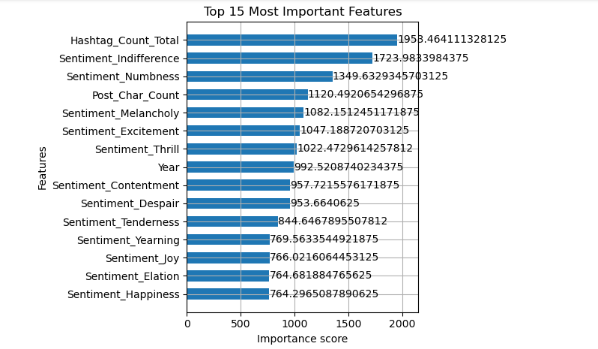


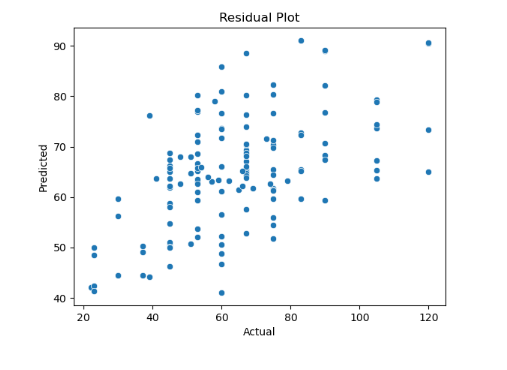

---

**Best XGBoost Model's Performance**

---

Fitting 6 folds for each of 16 candidates, totalling 96 fits

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.04, 'max_depth': 5, 'n_estimators': 350, 'subsample': 0.9}

Test Mean Squared Error: 278.34

Test R² Score: 0.3569

Train R² Score: 0.7648


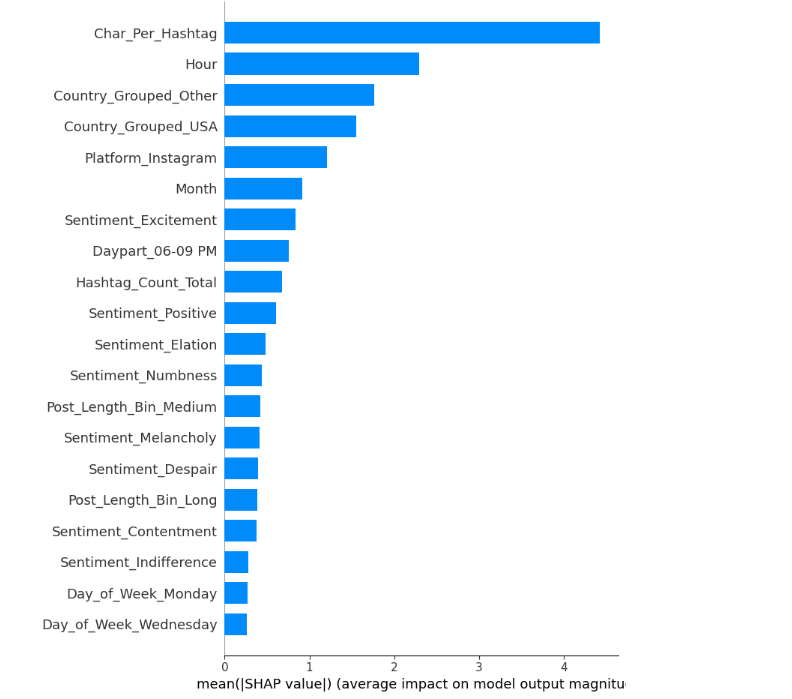


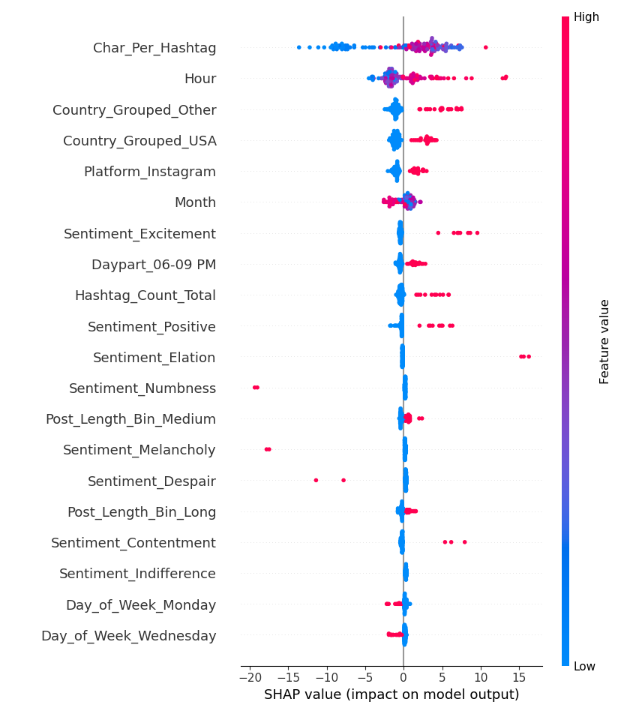

---

Although this version of XGBoost showed improved generalization, performance plateaued. That prompted me to explore **CatBoost**, which produced more stable results with simpler tuning.


---

Fitting 6 folds for each of 24 candidates, totalling 144 fits
Best Parameters: {'subsample': 0.8, 'learning_rate': 0.04, 'l2_leaf_reg': 1, 'iterations': 400, 'depth': 4}
Test MSE: 460.48
Test R² Score: 0.4008
Train R² Score: 0.5605


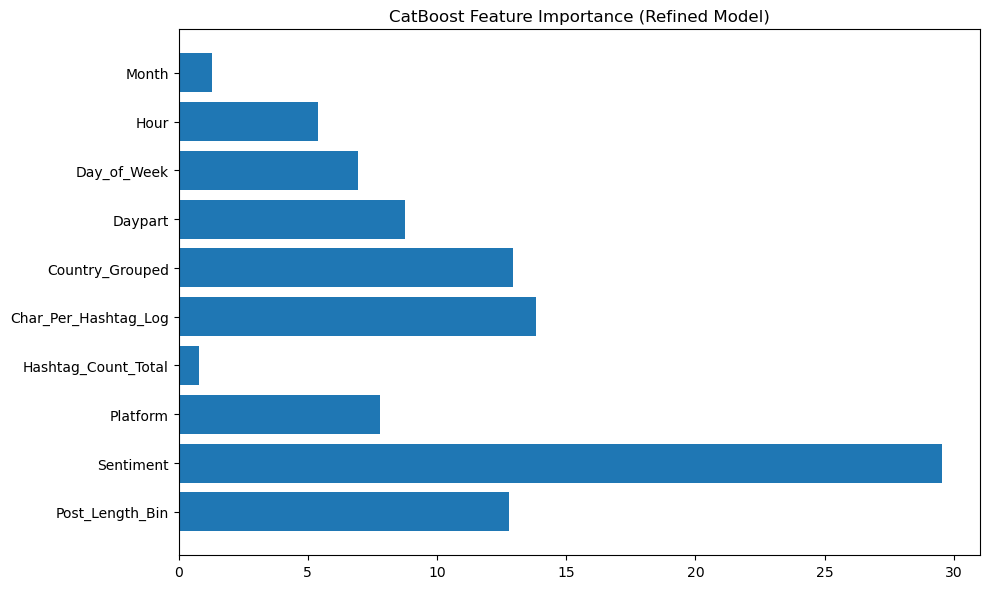

In [25]:
# Safety
df = df.copy()

# --------------------------------
# Feature Engineering
# --------------------------------
# Log-transform the Char_Per_Hashtag to reduce skew
df['Char_Per_Hashtag_Log'] = np.log1p(df['Char_Per_Hashtag'])

features = [
    'Post_Length_Bin', 'Sentiment', 'Platform', 'Hashtag_Count_Total',
    'Char_Per_Hashtag_Log', 'Country_Grouped', 'Daypart', 'Day_of_Week',
    'Hour', 'Month'
]

target = 'Engagement_Score'

categorical_features = [
    'Post_Length_Bin', 'Sentiment', 'Platform',
    'Country_Grouped', 'Daypart', 'Day_of_Week'
]

for col in categorical_features:
    df.loc[:, col] = df[col].astype(str)

X = df[features]
y = df[target]

# --------------------------------
# Train-Test Split
# --------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --------------------------------
# CatBoost Model Setup and Hyperparameter Tuning
# --------------------------------
cat_model = CatBoostRegressor(
    loss_function='RMSE',
    random_seed=42,
    verbose=0  # We'll control verbosity via early_stopping logging
)

param_dist = {
    'iterations': [300, 350, 400],
    'depth': [3, 4, 5],
    'learning_rate': [0.02, 0.03, 0.04],
    'l2_leaf_reg': [1, 3, 5],
    'subsample': [0.8, 0.9]
}

cv = RepeatedKFold(n_splits=3, n_repeats=2, random_state=42)

grid_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=24,  # Efficient exploration over the parameter space
    scoring='r2',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit the Grid Search with early stopping on a validation set
grid_search.fit(
    X_train,
    y_train,
    cat_features=categorical_features,
    eval_set=(X_test, y_test),
    early_stopping_rounds=30
)

# --------------------------------
# Evaluate the Best Model
# --------------------------------
best_cat = grid_search.best_estimator_
y_pred = best_cat.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, best_cat.predict(X_train))

print("Best Parameters:", grid_search.best_params_)
print(f"Test MSE: {mse:.2f}")
print(f"Test R² Score: {r2_test:.4f}")
print(f"Train R² Score: {r2_train:.4f}")

# --------------------------------
# Plot Feature Importance
# --------------------------------
feature_importances = best_cat.get_feature_importance()
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.title("CatBoost Feature Importance (Refined Model)")
plt.tight_layout()
plt.show()

## Visualization

Alongside the regression modeling, an interactive Tableau dashboard was built to explore how different features interact and influence engagement.

The dashboard allows users to filter by sentiment, country, platform, time of day, and more, making it easy to analyze patterns like.


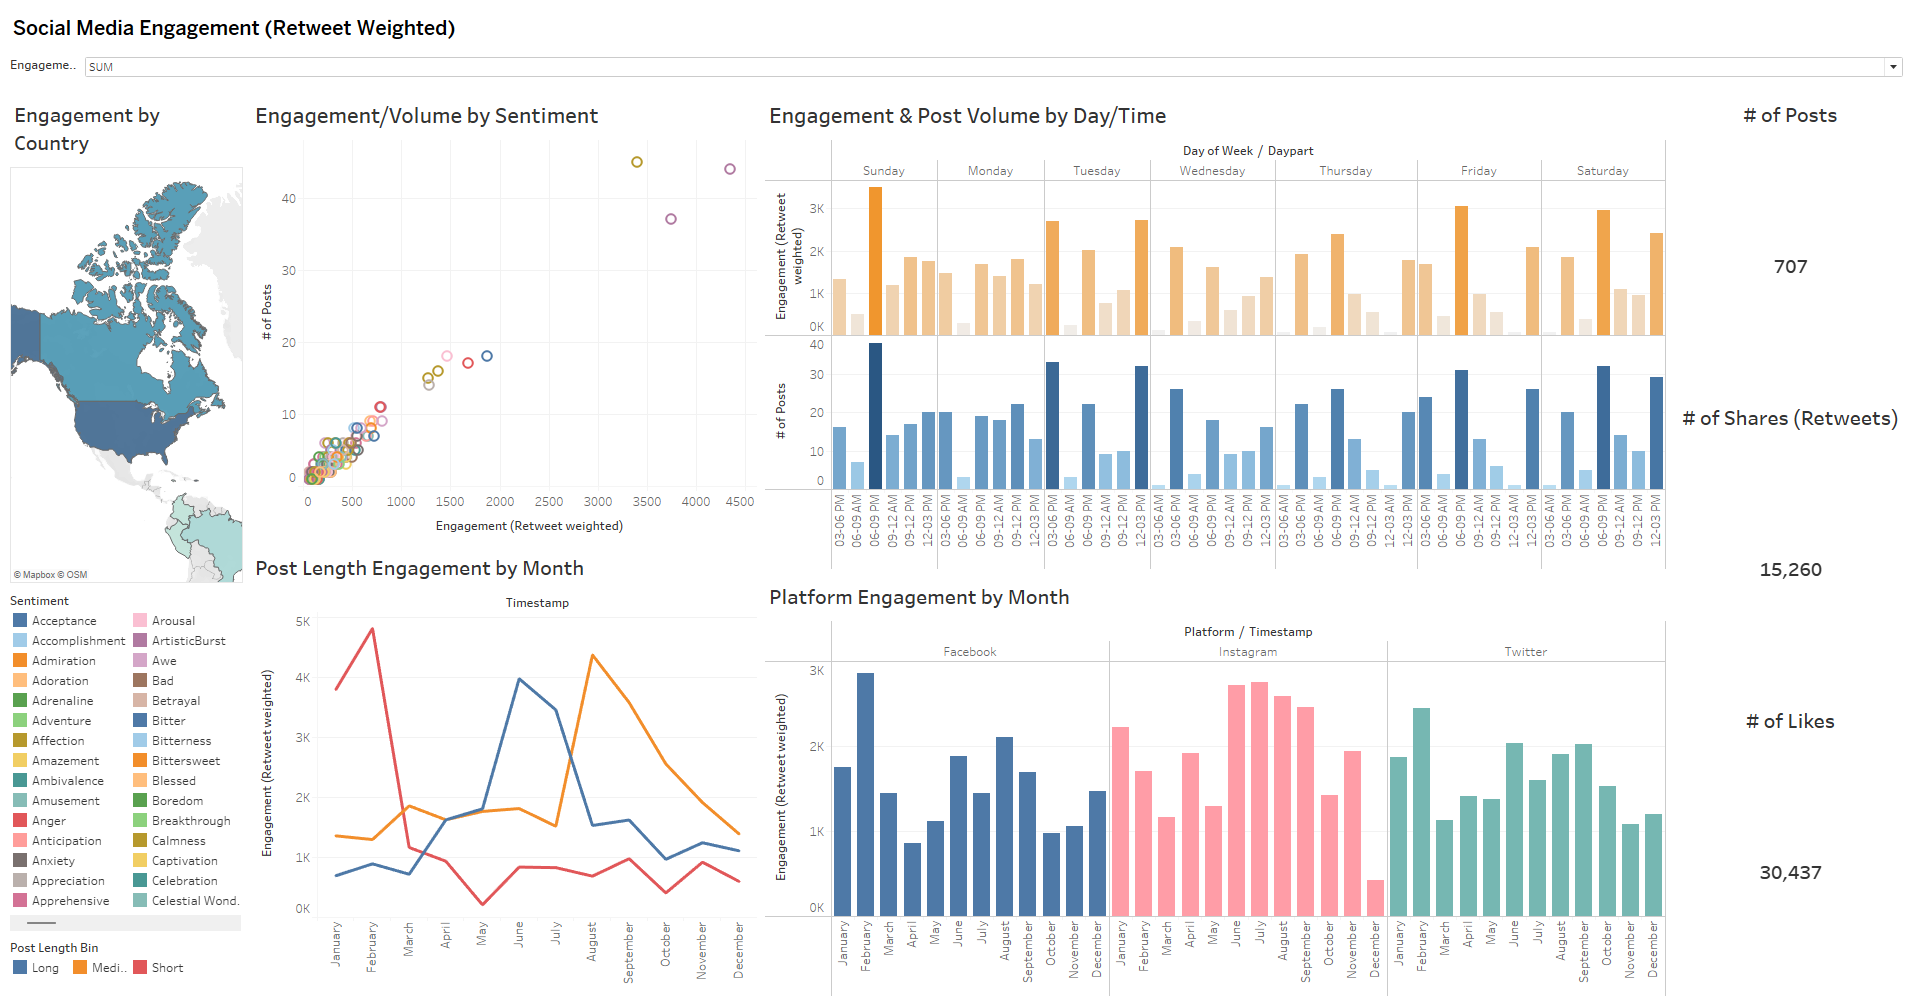



**Link to dashboard:** 

https://public.tableau.com/views/SocialMediaEngagementRetweetWeighted/Story1?:language=enUS&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link



